# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?
4.1 Evaluation metrics: session overview

    Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
    https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
! wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

--2023-10-08 11:33:45--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’

WA_Fn-UseC_-Telco-C 100%[===================>] 954.59K  4.54MB/s    in 0.2s    

2023-10-08 11:33:46 (4.54 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’ saved [977501/977501]



In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8026969481902059


## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines



In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).mean()

0.8026969481902059

In [11]:
1132 / 1409

0.8034066713981547

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [14]:
threshold = np.linspace(0,1,21)
scores = []
for t in threshold:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


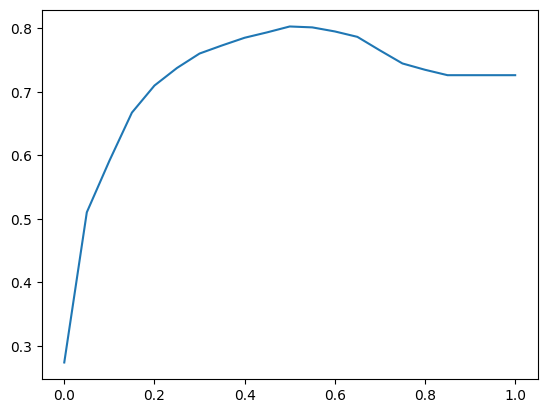

In [15]:
plt.plot(threshold, scores)

In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [18]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table
* Differente types of errors and correct decisions
* Arranging them in a table

In [19]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [20]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [25]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[921, 102],
       [176, 210]])

In [27]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [28]:
p = tp / (tp + fp)
p

0.6730769230769231

In [29]:
r = tp / (tp + fn)
r

0.5440414507772021

## ROC Curves
### TPR and FRP

In [30]:
tpr = tp / (tp + fn)
tpr 

0.5440414507772021

In [31]:
fpr = fp / (fp + tn)
fpr

0.09970674486803519

In [37]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [39]:
columns = ['threshold', 'tp','fp','fn','tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

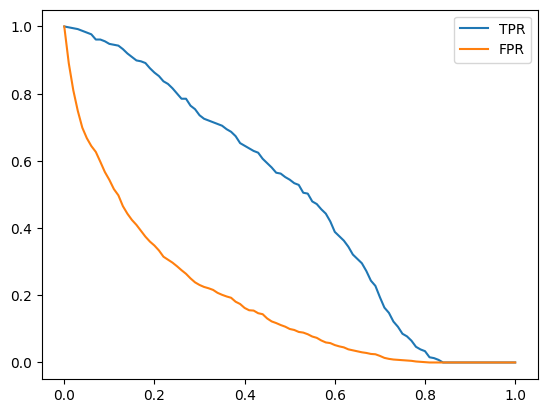

In [40]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random model

In [50]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [51]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [52]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp','fp','fn','tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [53]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

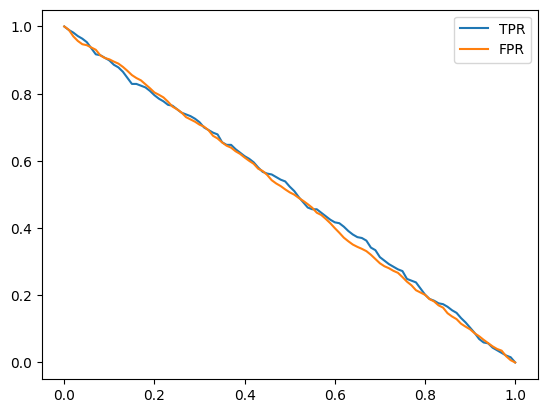

In [54]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal model

In [55]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [57]:
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [58]:
1 - y_val.mean()

0.7260468417317246

In [59]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [60]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


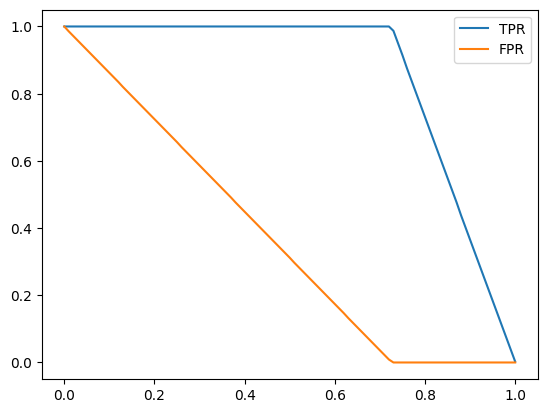

In [61]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everything together

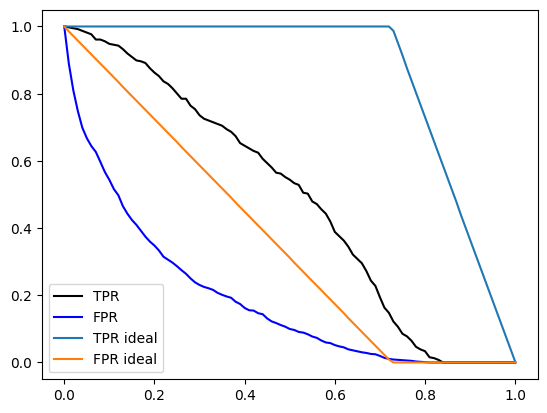

In [62]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()

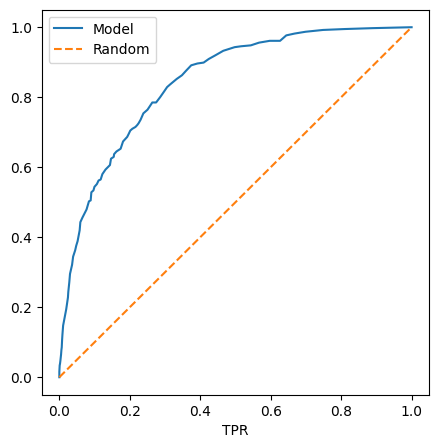

In [63]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0,1],[0,1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.xlabel('TPR')

plt.legend()

In [64]:
from sklearn.metrics import roc_curve

In [65]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

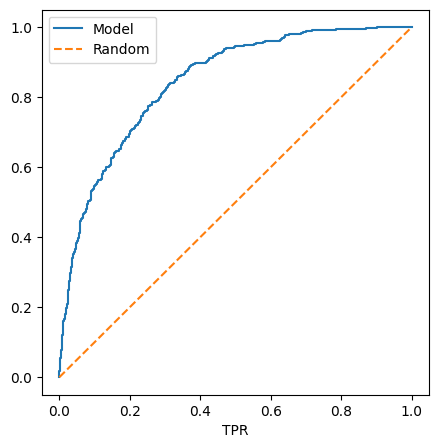

In [66]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1],[0,1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.xlabel('TPR')

plt.legend()

## Roc AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [67]:
from sklearn.metrics import auc

In [68]:
auc(fpr, tpr)

0.8438429084426077

In [69]:
auc(df_scores.fpr, df_scores.tpr)

0.8436745019980856

In [70]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [71]:
fpr, tpf, threshold = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438429084426077

In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
roc_auc_score(y_val, y_pred)

0.8438429084426077

In [74]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [75]:
import random

In [77]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84398

In [78]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84652

## 4.7 Crosss-Validation
* Evaluating the same model on differente subsets of data
* Getting the average prediction and the spread within predictions

In [79]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [80]:
dv, model = train(df_train, y_train, C=0.001)

In [81]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [82]:
y_pred = predict(df_val, dv, model)

In [83]:
from sklearn.model_selection import KFold

In [84]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 893.4 kB/s eta 0:00:00 0:00:01


In [85]:
from tqdm.auto import tqdm

In [87]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:01<00:04,  1.04it/s]

C=0.01 0.840 +- 0.009


 43%|████▎     | 3/7 [00:02<00:04,  1.01s/it]

C=0.1 0.841 +- 0.008


 57%|█████▋    | 4/7 [00:04<00:03,  1.03s/it]

C=0.5 0.841 +- 0.007


 71%|███████▏  | 5/7 [00:05<00:02,  1.03s/it]

C=1 0.841 +- 0.008


 86%|████████▌ | 6/7 [00:06<00:01,  1.05s/it]

C=5 0.841 +- 0.007


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

C=10 0.841 +- 0.008


In [88]:
scores

[0.8423122512579382,
 0.8458337471858032,
 0.8325306040537829,
 0.8336657447080643,
 0.8525462018763139]

In [89]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259